# Recommendation System

## Implémentation d'un algorithme de recommandation pour la plateforme de jeu Steam

Requirements

In [1]:
from cornac import Experiment
from cornac.data import Reader, Dataset
from cornac.metrics import MAP
from cornac.metrics import Recall, Precision
from cornac.models import BPR
from cornac.models import ItemKNN
from cornac.models import SVD
from cornac.models import UserKNN
from cornac.models import UserKNN, ItemKNN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import altair as alt
import cornac
import json
import numpy as np
import os
import pandas as pd
import re

/home/guillaume-charvolin/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Lien des datasets sur kaggle

https://www.kaggle.com/datasets/tamber/steam-video-games

https://www.kaggle.com/datasets/nikdavis/steam-store-games?select=steamspy_tag_data.csv

https://www.kaggle.com/datasets/nikdavis/steam-store-games?select=steam.csv


### Load Datasets

In [2]:
file_path_steam_user_info_on_game = './data/userData.csv'
raw_steam_user_info_on_game = pd.read_csv(file_path_steam_user_info_on_game)

file_path_tags_on_game_by_user = './data/tagsData.csv'
raw_tags_on_game_by_user = pd.read_csv(file_path_tags_on_game_by_user)

file_path_game_info = './data/itemData.csv'
raw_game_info = pd.read_csv(file_path_game_info)

In [3]:
print(raw_steam_user_info_on_game.shape)
print(raw_tags_on_game_by_user.shape)
print(raw_game_info.shape)

(200000, 5)
(29022, 372)
(27075, 18)


In [4]:
raw_steam_user_info_on_game.head(3)

,userid,name,type,value,limit
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0


In [5]:
raw_tags_on_game_by_user.head(3)

,appid,1980s,1990s,2.5d,2d,2d_fighter,360_video,3d,3d_platformer,3d_vision,...,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
0,10,144,564,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,550
1,20,0,71,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,122,0,0,0


In [6]:
raw_game_info.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99


### Preprocessing and Exploration

On fusionne les données raw_steam_user_info_on_game, au lieu d'avoir une ligne play et une ligne purchase on fait une ligne play et on met 0 en playtime si le jeux n'a pas été jouer.

In [7]:
def aggregate_user_playtime(data):
    play_data = data[data['type'] == 'play'].copy()
    purchase_data = data[data['type'] == 'purchase'].copy()

    play_data = play_data[['userid', 'name', 'value']].rename(columns={'name': 'gamename', 'value': 'playtime'})

    result = purchase_data[['userid', 'name']].rename(columns={'name': 'gamename'})
    result = result.merge(play_data, on=['userid', 'gamename'], how='left')
    result['playtime'] = result['playtime'].fillna(0)

    return result

merge_line_steam_user_info_on_game = aggregate_user_playtime(raw_steam_user_info_on_game)
print(raw_steam_user_info_on_game.head(4))
merge_line_steam_user_info_on_game.head(2)


      userid                        name      type  value  limit
0  151603712  The Elder Scrolls V Skyrim  purchase    1.0      0
1  151603712  The Elder Scrolls V Skyrim      play  273.0      0
2  151603712                   Fallout 4  purchase    1.0      0
3  151603712                   Fallout 4      play   87.0      0


,userid,gamename,playtime
0,151603712,The Elder Scrolls V Skyrim,273.0
1,151603712,Fallout 4,87.0


Renommons les colonnes du dataset des informations des jeux et transformons les temps moyens et median de jeu en heure comme dans le dataset des interactions pour que ce soit plus clair.

In [8]:
renamed_game_info = raw_game_info.rename(columns={'appid':'gameid', 'name': 'gamename'})

renamed_game_info['average_playtime'] = renamed_game_info['average_playtime'] / 60
renamed_game_info['median_playtime'] = renamed_game_info['median_playtime'] / 60

renamed_game_info.head(3)

,gameid,gamename,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,293.533333,5.283333,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,4.616667,1.033333,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,3.116667,0.566667,5000000-10000000,3.99


On ajoute le gameid à chaque ligne pour pouvoir croiser les données et avoir des informations sur le jeu, si le jeu n'est pas dans le dataset on le retire.

In [9]:
def add_gameid_to_user_info(user_data, game_data):
    user_data = user_data.copy()
    user_data.loc[:, 'normalized_gamename'] = user_data['gamename'].str.replace(r'\W+', '', regex=True).str.lower()
    game_data = game_data.copy()
    game_data.loc[:, 'normalized_gamename'] = game_data['gamename'].str.replace(r'\W+', '', regex=True).str.lower()
    
    merged_data = user_data.merge(
        game_data[['gameid', 'normalized_gamename']],
        left_on='normalized_gamename',
        right_on='normalized_gamename',
        how='left'
    )
    
    initial_row_count = len(merged_data)
    merged_data = merged_data.dropna(subset=['gameid'])
    removed_rows = initial_row_count - len(merged_data)
    
    print(f"Lignes supprimées : {removed_rows}")
    print(f"Lignes restantes : {len(merged_data)}")
    
    merged_data = merged_data[['userid', 'gamename', 'playtime', 'gameid']]
    
    return merged_data

with_gameid_steam_user_info = add_gameid_to_user_info(merge_line_steam_user_info_on_game, renamed_game_info)

Lignes supprimées : 40365
Lignes restantes : 89263


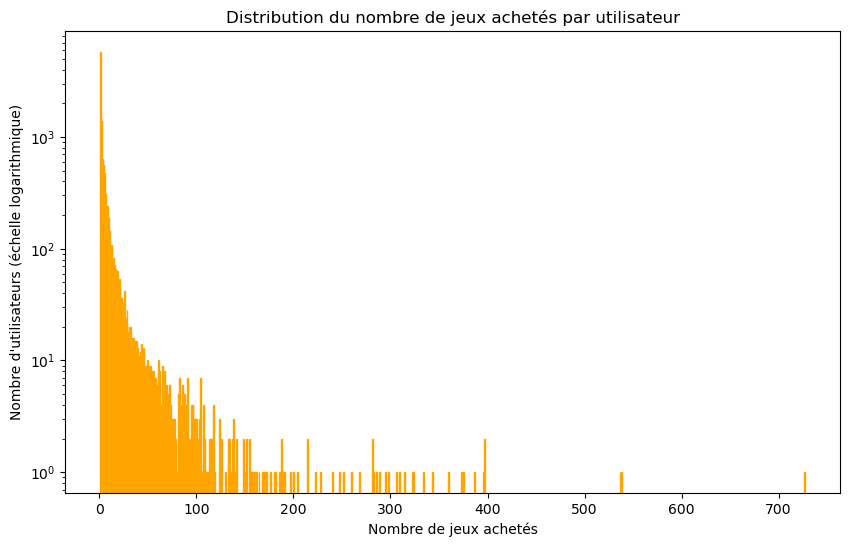

In [10]:
import matplotlib.pyplot as plt

user_purchase_counts = with_gameid_steam_user_info.groupby('userid').size()

plt.figure(figsize=(10, 6))
plt.hist(user_purchase_counts, bins=range(1, user_purchase_counts.max() + 1), edgecolor='orange')
plt.yscale('log')
plt.xlabel("Nombre de jeux achetés")
plt.ylabel("Nombre d'utilisateurs (échelle logarithmique)")
plt.title("Distribution du nombre de jeux achetés par utilisateur")
plt.show()


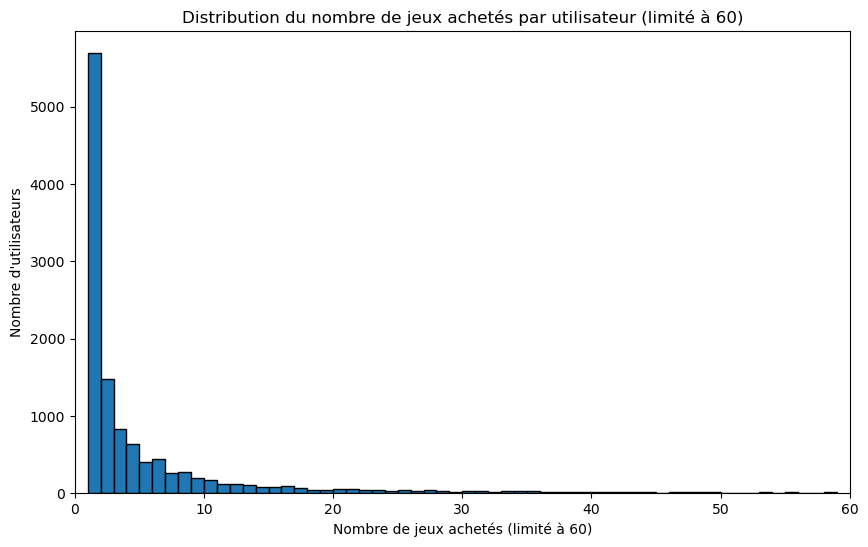

In [11]:
import matplotlib.pyplot as plt

user_purchase_counts = merge_line_steam_user_info_on_game.groupby('userid').size()
plt.figure(figsize=(10, 6))
plt.hist(user_purchase_counts, bins=range(1, 60), edgecolor='black')
plt.yscale('linear')
plt.xlabel("Nombre de jeux achetés (limité à 60)")
plt.ylabel("Nombre d'utilisateurs")
plt.title("Distribution du nombre de jeux achetés par utilisateur (limité à 60)")
plt.xlim(0, 60)
plt.show()


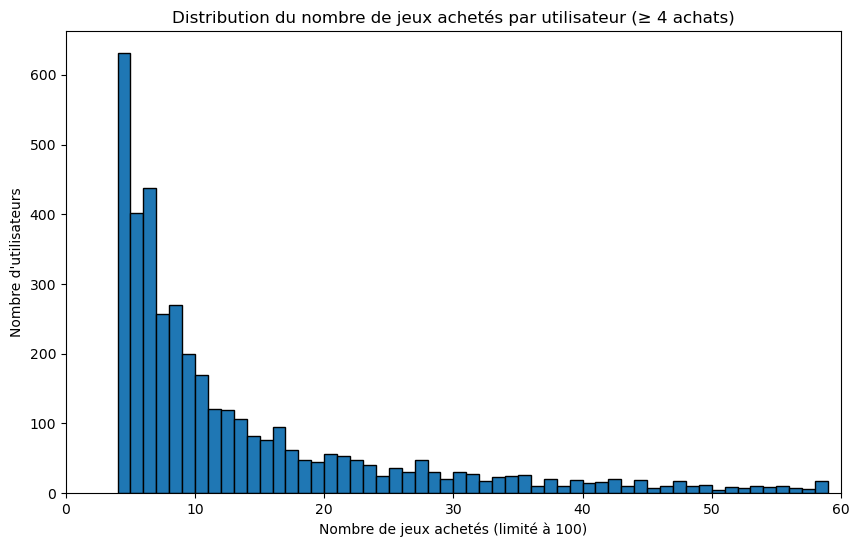

In [12]:
import matplotlib.pyplot as plt

user_purchase_counts = merge_line_steam_user_info_on_game.groupby('userid').size()

user_purchase_counts_filtered = user_purchase_counts[user_purchase_counts >= 4]

plt.figure(figsize=(10, 6))
plt.hist(user_purchase_counts_filtered, bins=range(4, 60), edgecolor='black')
plt.yscale('linear')
plt.xlabel("Nombre de jeux achetés (limité à 100)")
plt.ylabel("Nombre d'utilisateurs")
plt.title("Distribution du nombre de jeux achetés par utilisateur (≥ 4 achats)")
plt.xlim(0, 60)
plt.show()


On enlève les joueurs qui n'ont acheté que très peu de jeu car il sera dur de généraliser / tester sur leur cas, cela représente une grande partie du dataset malheureusement.

In [13]:
def filter_users_with_at_least_n_games(data, n):
    # Supprimer les doublons basés sur les colonnes 'userid' et 'gameid'
    data = data.drop_duplicates(subset=['userid', 'gamename'])
    
    # Compter le nombre de jeux par utilisateur
    user_game_counts = data['userid'].value_counts()
    valid_users = user_game_counts[user_game_counts >= n].index
    
    # Filtrer les utilisateurs avec au moins 'n' jeux
    filtered_data = data[data['userid'].isin(valid_users)]
    
    # Compter le nombre initial et final d'utilisateurs
    initial_user_count = data['userid'].nunique()
    remaining_user_count = filtered_data['userid'].nunique()
    removed_user_count = initial_user_count - remaining_user_count
    
    print(f"Joueurs éliminés : {removed_user_count}")
    print(f"Joueurs restants : {remaining_user_count}")
    
    return filtered_data

atleast4game_steam_user_info_on_game = filter_users_with_at_least_n_games(with_gameid_steam_user_info, 4)


Joueurs éliminés : 7770
Joueurs restants : 3708


In [14]:
user_purchase_counts = atleast4game_steam_user_info_on_game.groupby('userid').size()

median_purchases = user_purchase_counts.median()
print("Médiane du nombre de jeux achetés par utilisateur :", median_purchases)


Médiane du nombre de jeux achetés par utilisateur : 9.0


In [15]:
unique_games_in_user_data = atleast4game_steam_user_info_on_game['gamename'].nunique()
print("Nombre de jeux uniques dans atleast4game_steam_user_info_on_game :", unique_games_in_user_data)

unique_games_in_raw_data = raw_game_info['name'].nunique()
print("Nombre de jeux uniques dans raw_game_info :", unique_games_in_raw_data)


Nombre de jeux uniques dans atleast4game_steam_user_info_on_game : 3205
Nombre de jeux uniques dans raw_game_info : 27033


On enlève toutes les informations qui ne vont pas être utilisées pour la recommandation.

In [16]:
def clean_game_data(df):
    df = df[['gameid', 'developer', 'publisher', 'genres', 'steamspy_tags']].copy()

    def merge_and_clean_tags(row):
        tags = ' '.join(str(val).replace(';', ' ') for val in row if pd.notnull(val))
        tags_lower = tags.lower().split()
        unique_tags = ' '.join(sorted(set(tags_lower), key=tags_lower.index))
        return unique_tags

    df.loc[:, 'tags'] = df[['developer', 'publisher', 'genres', 'steamspy_tags']].apply(merge_and_clean_tags, axis=1)
    df = df[['gameid', 'tags']]
    
    return df

game_info_with_classic_tags = clean_game_data(renamed_game_info)
game_info_with_classic_tags.head()


,gameid,tags
0,10,valve action fps multiplayer
1,20,valve action fps multiplayer
2,30,valve action fps world war ii multiplayer
3,40,valve action fps multiplayer
4,50,gearbox software valve action fps sci-fi


On ajoute les tags populaires à la colonne tags, il s'agit des tags qui correspondent au votes des utilisateurs.

In [17]:
def add_popular_tags(cleaned_df, game_info_tags):
    for index, row in cleaned_df.iterrows():
        game_id = row['gameid']
        tag_row = game_info_tags[game_info_tags['appid'] == game_id]
        if tag_row.empty:
            continue
        total_tags = tag_row.iloc[0, 1:].sum()
        threshold = total_tags / 10
        existing_tags = set(row['tags'].split())
        selected_tags = {
            tag for tag, count in tag_row.iloc[0, 1:].items()
            if count >= threshold and tag not in existing_tags
        }
        all_tags = existing_tags.union(selected_tags)
        cleaned_df.at[index, 'tags'] = ' '.join(all_tags)
    
    return cleaned_df

game_info_with_all_tags = add_popular_tags(game_info_with_classic_tags, raw_tags_on_game_by_user)
game_info_with_classic_tags.head()


,gameid,tags
0,10,valve fps action multiplayer
1,20,valve fps action multiplayer
2,30,world_war_ii war multiplayer ii valve fps acti...
3,40,multiplayer valve fps action shooter classic
4,50,gearbox software sci-fi valve fps action


Les ratings seront toujours à 1.

In [18]:
def use_playtime_function_transform_to_rating(data):
    data['ratings'] = data['playtime'].apply(lambda x: 1)
    return data[['userid', 'gameid', 'ratings']]

ratings_data = use_playtime_function_transform_to_rating(atleast4game_steam_user_info_on_game)
print(ratings_data.shape)
ratings_data.head()

(78171, 3)


,userid,gameid,ratings
0,151603712,72850.0,1
1,151603712,377160.0,1
2,151603712,17390.0,1
3,151603712,22380.0,1
4,151603712,550.0,1


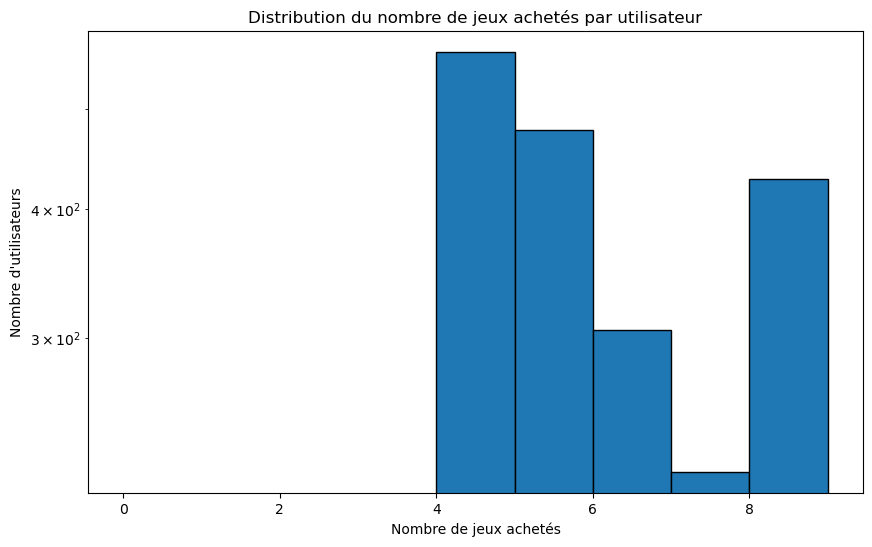

In [19]:
# Testing Purposes

import matplotlib.pyplot as plt

user_purchase_counts = ratings_data.groupby('userid').size()
plt.figure(figsize=(10, 6))
plt.hist(user_purchase_counts, bins=range(0, 10), edgecolor='black')
plt.yscale('log')
plt.xlabel("Nombre de jeux achetés")
plt.ylabel("Nombre d'utilisateurs")
plt.title("Distribution du nombre de jeux achetés par utilisateur")
plt.show()


## Split 

In [20]:
from cornac.eval_methods import BaseMethod

class CustomSplit(BaseMethod):
    def __init__(
        self,
        data,
        rating_threshold=1.0,
        seed=None,
        exclude_unknowns=True,
        verbose=False,
        **kwargs,
    ):
        super().__init__(
            data=data,
            rating_threshold=rating_threshold,
            seed=seed,
            exclude_unknowns=exclude_unknowns,
            verbose=verbose,
            **kwargs,
        )
        
        self._split()
        
    def _split(self):
        train_idx = []
        test_idx = []
        
        for uid in np.unique(self.data[:, 0]):
            user_interactions = np.where(self.data[:, 0] == uid)[0]
            
            num_test = max(1, int(len(user_interactions) * 0.25))
            test_interactions = self.rng.choice(user_interactions, num_test, replace=False)
            test_idx.extend(test_interactions)
            
            train_interactions = [idx for idx in user_interactions if idx not in test_interactions]
            train_idx.extend(train_interactions)
        
        train_data = self.data[train_idx]
        test_data = self.data[test_idx]

        self.custom_train_data = train_data
        self.custom_test_data = test_data
        
        self.build(train_data=train_data, test_data=test_data, val_data=None)

In [21]:
eval_method = CustomSplit(data=ratings_data[['userid', 'gameid', 'ratings']].to_numpy(), seed=42)
train_size = len(eval_method.train_set.uir_tuple[0])
test_size = len(eval_method.test_set.uir_tuple[0])

print(f"Train size: {train_size}, Test size: {test_size}")
print(f"Ratio: {test_size / train_size:.2f}")


Train size: 59758, Test size: 18186
Ratio: 0.30


## Collaborative Filtering

In [22]:
def save_model_performance(path, model_name, average_results):

    os.makedirs(os.path.dirname(path), exist_ok=True)

    output_data = {
        'model_name': model_name,
        'performance': average_results
    }

    with open(path, 'w') as file:
        json.dump(output_data, file, indent=4)

    print(f"\n'{model_name}': results: saved: '{path}'.")


### UserKNN

In [23]:
k_values_neighbor = [5, 20, 40, 50, 60, 70, 80, 300, 380, 500, 580, 600, 640, 700]

models_dict = {k: UserKNN(k=k, similarity="cosine") for k in k_values_neighbor}

models_dict = {}
models_dict["UserKNN"] = {}
for k in k_values_neighbor:
    models_dict["UserKNN"][k] = UserKNN(k=k, similarity="cosine")

average_results = {k: {'UserKNN': {'MAP': []}} for k in k_values_neighbor}
for k in k_values_neighbor:
    print(f"\nTesting k = {k}")
    
    user_knn = models_dict['UserKNN'][k]
    
    experiment = Experiment(
        eval_method=eval_method,
        models=[user_knn],
        metrics=[MAP()]
    )
    experiment.run()

    for result in experiment.result:
        model_name = result.model_name
        average_results[k][model_name]['MAP'].append(result.metric_avg_results['MAP'])

for k in k_values_neighbor:
    map_value = average_results[k]['UserKNN']['MAP'][0] * 100
    print(f"UserKNN - k={k} - MAP: {map_value:.1f}%")

save_model_performance("./recsys_result/userKNN.json", "UserKNN", average_results)




Testing k = 5


100%|██████████| 3708/3708 [00:00<00:00, 90548.79it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.0038 |    0.2793 |   5.6974


Testing k = 20


100%|██████████| 3708/3708 [00:00<00:00, 85896.35it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.0096 |    0.2929 |   5.9607


Testing k = 40


100%|██████████| 3708/3708 [00:00<00:00, 105303.46it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.0176 |    0.2574 |   6.0629


Testing k = 50


100%|██████████| 3708/3708 [00:00<00:00, 83335.45it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.0216 |    0.2626 |   5.9159


Testing k = 60


100%|██████████| 3708/3708 [00:00<00:00, 96732.63it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.0256 |    0.2629 |   6.2336


Testing k = 70


100%|██████████| 3708/3708 [00:00<00:00, 78253.44it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.0290 |    0.2850 |   6.1366


Testing k = 80


100%|██████████| 3708/3708 [00:00<00:00, 93362.86it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.0328 |    0.2787 |   5.9604


Testing k = 300


100%|██████████| 3708/3708 [00:00<00:00, 80217.45it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.1586 |    0.2618 |   6.2390


Testing k = 380


100%|██████████| 3708/3708 [00:00<00:00, 91138.31it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.2194 |    0.2896 |   6.1351


Testing k = 500


100%|██████████| 3708/3708 [00:00<00:00, 75785.16it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.2643 |    0.2810 |   5.9715


Testing k = 580


100%|██████████| 3708/3708 [00:00<00:00, 114444.82it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.2762 |    0.2615 |   5.8761


Testing k = 600


100%|██████████| 3708/3708 [00:00<00:00, 84979.26it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.2776 |    0.2800 |   5.9865


Testing k = 640


100%|██████████| 3708/3708 [00:00<00:00, 110864.24it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.2806 |    0.2579 |   5.8187


Testing k = 700


100%|██████████| 3708/3708 [00:00<00:00, 91082.80it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
UserKNN | 0.2822 |    0.2638 |   6.1003

UserKNN - k=5 - MAP: 0.4%
UserKNN - k=20 - MAP: 1.0%
UserKNN - k=40 - MAP: 1.8%
UserKNN - k=50 - MAP: 2.2%
UserKNN - k=60 - MAP: 2.6%
UserKNN - k=70 - MAP: 2.9%
UserKNN - k=80 - MAP: 3.3%
UserKNN - k=300 - MAP: 15.9%
UserKNN - k=380 - MAP: 21.9%
UserKNN - k=500 - MAP: 26.4%
UserKNN - k=580 - MAP: 27.6%
UserKNN - k=600 - MAP: 27.8%
UserKNN - k=640 - MAP: 28.1%
UserKNN - k=700 - MAP: 28.2%

'UserKNN': results: saved: './recsys_result/userKNN.json'.


### ItemKNN

In [24]:
k_values_neighbor = [5, 20, 60, 100, 300]

average_results = {k: {'ItemKNN': {'MAP': []}} for k in k_values_neighbor}
models_dict["ItemKNN"] = {}
for k in k_values_neighbor:
    models_dict["ItemKNN"][k] = ItemKNN(k=k, similarity="cosine")

for k in k_values_neighbor:
    print(f"\nTesting k = {k}")
    
    item_knn = models_dict['ItemKNN'][k]

    experiment = Experiment(
        eval_method=eval_method,
        models=[item_knn],
        metrics=[MAP()]
    )
    experiment.run()

    for result in experiment.result:
        model_name = result.model_name
        average_results[k]['ItemKNN']['MAP'].append(result.metric_avg_results['MAP'])

for k in k_values_neighbor:
    map_value = average_results[k]['ItemKNN']['MAP'][0] * 100
    print(f"ItemKNN - k={k} - MAP: {map_value:.1f}%")

save_model_performance("./recsys_result/itemKNN.json", "ItemKNN", average_results)



Testing k = 5


100%|██████████| 3008/3008 [00:00<00:00, 96490.84it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
ItemKNN | 0.0028 |    0.1328 |   7.6907


Testing k = 20


100%|██████████| 3008/3008 [00:00<00:00, 88708.42it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
ItemKNN | 0.0072 |    0.1419 |   7.0989


Testing k = 60


100%|██████████| 3008/3008 [00:00<00:00, 115577.74it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
ItemKNN | 0.0136 |    0.1329 |   6.6295


Testing k = 100


100%|██████████| 3008/3008 [00:00<00:00, 105513.55it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
ItemKNN | 0.0162 |    0.1210 |   6.5292


Testing k = 300


100%|██████████| 3008/3008 [00:00<00:00, 117157.59it/s]



TEST:
...
        |    MAP | Train (s) | Test (s)
------- + ------ + --------- + --------
ItemKNN | 0.0185 |    0.1172 |   6.7600

ItemKNN - k=5 - MAP: 0.3%
ItemKNN - k=20 - MAP: 0.7%
ItemKNN - k=60 - MAP: 1.4%
ItemKNN - k=100 - MAP: 1.6%
ItemKNN - k=300 - MAP: 1.8%

'ItemKNN': results: saved: './recsys_result/itemKNN.json'.


### SVD

In [25]:
k_values_latent = [3, 6, 9, 14, 20, 27, 40, 100]
num_runs = 10

average_results = {k: {'SVD': {'MAP': []}} for k in k_values_latent}
models_dict["SVD"] = {}
for k_latent in k_values_latent:
    models_dict["SVD"][k_latent] = SVD(k=k_latent)

for k_latent in k_values_latent:
    print(f"\nTesting k (latent factors) = {k_latent}")
    
    for _ in range(num_runs):
        svd_model = models_dict['SVD'][k_latent]
        
        experiment = Experiment(
            eval_method=eval_method,
            models=[svd_model],
            metrics=[MAP()]
        )
        experiment.run()

        for result in experiment.result:
            model_name = result.model_name
            average_results[k_latent]['SVD']['MAP'].append(result.metric_avg_results['MAP'])

for k in k_values_latent:
    map_avg = np.mean(average_results[k]['SVD']['MAP']) * 100
    print(f"SVD - k (latent factors)={k} - MAP: {map_avg:.1f}%")

save_model_performance("./recsys_result/SVD.json", "SVD", average_results)



Testing k (latent factors) = 3

TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
SVD | 0.0024 |    0.0148 |   2.7174



/home/guillaume-charvolin/.local/lib/python3.12/site-packages/cornac/models/recommender.py:322: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(



TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
SVD | 0.0022 |    0.0112 |   2.7077


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
SVD | 0.0021 |    0.0163 |   2.6758


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
SVD | 0.0021 |    0.0093 |   2.6864


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
SVD | 0.0021 |    0.0098 |   2.6894


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
SVD | 0.0021 |    0.0099 |   2.7011


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
SVD | 0.0021 |    0.0117 |   2.6904


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
SVD | 0.0021 |    0.0110 |   2.6781


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
SVD | 0.0021 |    0.0102 |   2.6715


TEST:
...
    |    MAP | Train (s) | Te

### BRP

In [26]:
k_values_latent = [3, 6, 9, 14, 20, 27, 40, 100]
num_runs = 10

models_dict["BPR"] = {}
average_results = {k: {'BPR': {'MAP': []}} for k in k_values_latent}
for k_latent in k_values_latent:
    print(f"\nTesting k (latent factors) = {k_latent}")

    for _ in range(num_runs):
        bpr_model = BPR(k=k_latent, max_iter=100, learning_rate=0.01)
        
        experiment = Experiment(
            eval_method=eval_method,
            models=[bpr_model],
            metrics=[MAP()]
        )
        experiment.run()

        for result in experiment.result:
            average_results[k_latent]['BPR']['MAP'].append(result.metric_avg_results['MAP'])
        
        models_dict['BPR'][k_latent] = bpr_model

for k in k_values_latent:
    map_avg = np.mean(average_results[k]['BPR']['MAP']) * 100
    print(f"BPR - k (latent factors)={k} - MAP: {map_avg:.1f}%")

save_model_performance("./recsys_result/BPR.json", "BPR", average_results)



Testing k (latent factors) = 3

TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
BPR | 0.1548 |    0.1094 |   2.6744


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
BPR | 0.1534 |    0.0935 |   2.6888


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
BPR | 0.1584 |    0.0927 |   2.6712


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
BPR | 0.1559 |    0.0829 |   2.6334


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
BPR | 0.1481 |    0.0969 |   2.6304


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
BPR | 0.1571 |    0.0857 |   2.5589


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
BPR | 0.1509 |    0.0909 |   2.7165


TEST:
...
    |    MAP | Train (s) | Test (s)
--- + ------ + --------- + --------
BPR | 0.1507 |    0.0878 |   2.6725


TEST:
.

## Content Based TF-IDF

### TF-IDF Utils

In [27]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json

test_data = pd.DataFrame(eval_method.custom_test_data, columns=['userid', 'gameid', 'rating'])
train_data = pd.DataFrame(eval_method.custom_train_data, columns=['userid', 'gameid', 'rating'])

gameid_to_name = dict(zip(renamed_game_info['gameid'], renamed_game_info['gamename']))

def create_tfidf_matrix(data, feature_col='tags'):
    vectorizer = TfidfVectorizer()
    matrix = vectorizer.fit_transform(data[feature_col])
    id_to_index = {game_id: idx for idx, game_id in enumerate(data['gameid'])}
    return matrix, id_to_index

tfidf_matrix, gameid_to_index = create_tfidf_matrix(game_info_with_all_tags)

def calculate_map(recommendations, test_data):
    def mean_average_precision_at_k(recommended, relevant):
        score, num_hits = 0.0, 0.0
        for i, rec in enumerate(recommended):
            if rec in relevant:
                num_hits += 1.0
                score += num_hits / (i + 1.0)
        return score / max(1.0, len(relevant))
    
    average_precisions = [
        mean_average_precision_at_k(rec_items, test_data[test_data['userid'] == user]['gameid'].tolist())
        for user, rec_items in recommendations.items() if test_data[test_data['userid'] == user]['gameid'].tolist()
    ]
    return np.mean(average_precisions) if average_precisions else 0.0


### Mean Vector

In [52]:
def recommend_for_group(game_ids, tfidf_matrix, id_to_index, top_k=100, vectorizer=np.mean):
    indices = [id_to_index[game_id] for game_id in game_ids if game_id in id_to_index]
    if not indices:
        return []
    
    group_vector = vectorizer(tfidf_matrix[indices].toarray(), axis=0)
    sim_scores = cosine_similarity([group_vector], tfidf_matrix).flatten()
    sim_scores[indices] = 0
    similar_indices = np.argsort(sim_scores)[::-1][:top_k]
    
    return [game_info_with_all_tags['gameid'].iloc[i] for i in similar_indices]

def generate_recommendations(train_data, tfidf_matrix, gameid_to_index, vectorizer=np.mean, top_k=100):
    return {
        user_id: recommend_for_group(
            train_data[train_data['userid'] == user_id]['gameid'].values, 
            tfidf_matrix, 
            gameid_to_index,
            top_k=top_k,
            vectorizer=vectorizer,
        ) 
        for user_id in train_data['userid'].unique()
    }

mean_recommendations = generate_recommendations(train_data, tfidf_matrix, gameid_to_index)

map_score_test = calculate_map(mean_recommendations, test_data)
print(f"Mean Average Precision (MAP) on Test Set: {map_score_test:.2%}")

save_model_performance("./recsys_result/TFIDF_mean_vector.json", "TF-IDF", map_score_test)



Mean Average Precision (MAP) on Test Set: 12.77%

'TF-IDF': results: saved: './recsys_result/TFIDF_mean_vector.json'.


### Max Vector

In [29]:
max_recommendations = generate_recommendations(train_data, tfidf_matrix, gameid_to_index, np.max)

map_score_test = calculate_map(max_recommendations, test_data)
print(f"Mean Average Precision (MAP) on Test Set: {map_score_test:.2%}")

save_model_performance("./recsys_result/TFIDF_max_vector.json", "TF-IDF", map_score_test)

Mean Average Precision (MAP) on Test Set: 10.05%

'TF-IDF': results: saved: './recsys_result/TFIDF_max_vector.json'.


### Aggregated Vector

In [30]:
from collections import Counter
def recommend_for_group_aggregated(game_ids, tfidf_matrix, id_to_index, top_k=100):
    aggregated_recommendations = Counter()
    
    for game_id in game_ids:
        if game_id in id_to_index:

            idx = id_to_index[game_id]
            sim_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
            sim_scores[idx] = 0

            similar_games_idx = np.argsort(sim_scores)[::-1][:top_k]
            similar_games = [game_info_with_all_tags['gameid'].iloc[i] for i in similar_games_idx]
            
            aggregated_recommendations.update(similar_games)

    most_common_games = [game_id for game_id, _ in aggregated_recommendations.most_common(top_k)]
    return most_common_games

def generate_aggregated_recommendations(train_data, tfidf_matrix, gameid_to_index):
    return {
        user_id: recommend_for_group_aggregated(
            train_data[train_data['userid'] == user_id]['gameid'].values, 
            tfidf_matrix, 
            gameid_to_index
        ) 
        for user_id in train_data['userid'].unique()
    }

aggregated_recommendations = generate_aggregated_recommendations(train_data, tfidf_matrix, gameid_to_index)

map_score_test = calculate_map(aggregated_recommendations, test_data)
print(f"Mean Average Precision (MAP) on Test Set: {map_score_test:.2%}")

save_model_performance("./recsys_result/TFIDF_aggregated_test.json", "TF-IDF Aggregated", map_score_test)


Mean Average Precision (MAP) on Test Set: 10.11%

'TF-IDF Aggregated': results: saved: './recsys_result/TFIDF_aggregated_test.json'.


## Show recommendations

### The users we will show recommendations for

In [31]:

sample_users = []

# 2 users with 4 games
users_with_4_games = ratings_data['userid'].value_counts().loc[lambda x: x == 4].index[:2]
sample_users.extend(users_with_4_games)

# 2 users with 10 games
user_with_10_games = ratings_data['userid'].value_counts().loc[lambda x: x == 10].index[:2]
sample_users.extend(user_with_10_games)

# 2 users with 20 games
user_with_20_games = ratings_data['userid'].value_counts().loc[lambda x: x == 20].index[:2]
sample_users.extend(user_with_20_games)

sample_users = list(sample_users)


### All the useful functions

In [32]:
def is_in_train_or_test(gameid, userid, eval_method):
    uid_map = eval_method.train_set.uid_map
    iid_map = eval_method.train_set.iid_map
    
    uid = uid_map.get(userid)
    iid = iid_map.get(gameid)
    
    if uid is None or iid is None:
        return "not_found"
    
    train_users, train_games, _ = eval_method.train_set.uir_tuple
    test_users, test_games, _ = eval_method.test_set.uir_tuple

    in_train = (uid in train_users) and (iid in train_games[train_users == uid])
    in_test = (uid in test_users) and (iid in test_games[test_users == uid])
    
    if in_train:
        return "train_set"
    elif in_test:
        return "test_set"
    else:
        return "not_found"


In [33]:
def user_info_train_test_game(sample_users, eval_method):
    gameid_to_name = dict(zip(renamed_game_info['gameid'], renamed_game_info['gamename']))

    for user_id in sample_users:
        train_games = []
        test_games = []
        
        user_games = ratings_data[ratings_data['userid'] == user_id]['gameid'].unique()
        
        for game_id in user_games:
            set_type = is_in_train_or_test(game_id, user_id, eval_method)
            if set_type == "train_set":
                train_games.append(gameid_to_name.get(game_id, "Unknown Game"))
            elif set_type == "test_set":
                test_games.append(gameid_to_name.get(game_id, "Unknown Game"))
        
        print(f"User {user_id}:")
        print(f"  Train Set Games: {sorted(train_games)}")
        print(f"  Test Set Games: {sorted(test_games)}")



In [53]:
def get_game_position_in_recommendations(game_id, recommendations):
    try:
        return recommendations.index(game_id) + 1
    except ValueError:
        return None
def display_test_game_positions_in_recommendations(recommendations, test_data, sample_users, top_x=10):

    gameid_to_name = dict(zip(renamed_game_info['gameid'], renamed_game_info['gamename']))
    
    for user_id in sample_users:
        user_test_games = test_data[test_data['userid'] == user_id]['gameid'].tolist()
        user_recommendations = recommendations.get(user_id, [])
        
        print(f"User {user_id} - Test Game Positions in Recommendations:")
        for test_game in user_test_games:
            position = get_game_position_in_recommendations(test_game, user_recommendations)
            game_name = gameid_to_name.get(test_game, "Unknown Game")
            if position:
                print(f"  [{game_name}]: {position}")
            else:
                print(f"  [{game_name}]: Not in Top {len(user_recommendations)} Recommendations")
    
        print(f"\nUser {user_id} - Top {top_x} Recommended Games:")
        for i, recommended_game_id in enumerate(user_recommendations[:top_x], start=1):
            recommended_game_name = gameid_to_name.get(recommended_game_id, "Unknown Game")
            print(f"  {i}. {recommended_game_name}")
        print("\n")


In [35]:
def get_train_games_for_user(user_id, eval_method):
    train_data = eval_method.custom_train_data
    user_train_games = train_data[train_data[:, 0] == user_id][:, 1]
    return user_train_games

def get_test_games_for_user(user_id, eval_method):
    test_data = eval_method.custom_test_data
    user_test_games = test_data[test_data[:, 0] == user_id][:, 1]
    return user_test_games

#user_id = sample_users[0]
#test_games = get_test_games_for_user(user_id, eval_method)
#print("Test Games for User:", test_games)

In [36]:
def get_top_k_recommendations(model, user_id, eval_method, k=10):
    user_idx = eval_method.train_set.uid_map.get(user_id)
    if user_idx is None:
        return []
    
    scores = model.score(user_idx).flatten()
    train_games = set(get_train_games_for_user(user_id, eval_method))
    top_items_idx = np.argsort(scores)[::-1]
    inverse_iid_map = {v: k for k, v in eval_method.train_set.iid_map.items()}
    top_game_ids = [inverse_iid_map[i] for i in top_items_idx if inverse_iid_map[i] not in train_games][:k]
    
    return top_game_ids

#top_k_recommendations = get_top_k_recommendations(models_dict['UserKNN'][300], sample_users[0], eval_method, k=10)
#print(top_k_recommendations)


In [37]:
def get_game_ranking(model, user_id, game_id, eval_method):
    user_idx = eval_method.train_set.uid_map.get(user_id)
    item_idx = eval_method.train_set.iid_map.get(game_id)
    if user_idx is None or item_idx is None:
        return None
    scores = model.score(user_idx).flatten()
    sorted_indices = np.argsort(scores)[::-1]
    ranking_position = np.where(sorted_indices == item_idx)[0][0] + 1
    
    return ranking_position

#ranking = get_game_ranking(models_dict['UserKNN'][300], sample_users[0], 363330, eval_method)
#print(f"Classement du jeu {363330}: {ranking}")


In [38]:
def get_recommendations_and_rankings(model, user_id, game_ids, eval_method, k=10):
    top_k_recommendations = get_top_k_recommendations(model, user_id, eval_method, k)
    
    rankings = {}
    for game_id in game_ids:
        ranking = get_game_ranking(model, user_id, game_id, eval_method)
        rankings[game_id] = ranking
    
    return top_k_recommendations, rankings


In [39]:
def display_user_recommendations_with_test_positions(model, sample_users, eval_method, top_k=10):

    gameid_to_name = dict(zip(renamed_game_info['gameid'], renamed_game_info['gamename']))
    
    for user_id in sample_users:
        test_games = get_test_games_for_user(user_id, eval_method)
        
        top_k_recommendations = get_top_k_recommendations(model, user_id, eval_method, k=top_k)
        
        print(f"User {user_id} - Test Game Positions in Recommendations:")
        for test_game in test_games:
            position = get_game_ranking(model, user_id, test_game, eval_method)
            game_name = gameid_to_name.get(test_game, "Unknown Game")
            print(f"  [{game_name}]: {position}")

        print(f"\nUser {user_id} - Top {top_k} Recommended Games:")
        for i, recommended_game_id in enumerate(top_k_recommendations, start=1):
            recommended_game_name = gameid_to_name.get(recommended_game_id, "Unknown Game")
            print(f"  {i}. {recommended_game_name}")
        print("\n")

### Results recommandations

Informations of which game are known by the model \(train set Games) and which one should be recommended by the model \(test set Games).

In [40]:
user_info_train_test_game(sample_users, eval_method)

User 134832575:
  Train Set Games: ['Freestyle 2: Street Basketball', 'GunZ 2: The Second Duel', 'Team Fortress 2']
  Test Set Games: ['Dota 2']
User 251634185:
  Train Set Games: ['Dungeons & Dragons Online®', 'Panzar', 'Requiem']
  Test Set Games: ['Path of Exile']
User 24858005:
  Train Set Games: ['Alpha Prime', 'Call of Duty®: Modern Warfare® 2', 'Counter-Strike: Source', 'Half-Life 2', 'Half-Life 2: Deathmatch', 'Half-Life 2: Lost Coast', 'Half-Life Deathmatch: Source', 'Left 4 Dead']
  Test Set Games: ['Call of Duty®: Black Ops', 'Half-Life: Source']
User 298715051:
  Train Set Games: ['AdVenture Capitalist', 'Clicker Heroes', 'Counter-Strike Nexon: Zombies', 'Counter-Strike: Global Offensive', 'Crusaders of the Lost Idols', 'Dungeon Defenders II', 'RaceRoom Racing Experience', 'Unturned']
  Test Set Games: ['Endless Sky', 'Trove']
User 82174211:
  Train Set Games: ['Age of Empires® III: Complete Collection', 'Borderlands 2', 'Clicker Heroes', 'Counter-Strike: Global Offensive',

### For UserKNN

In [56]:
display_user_recommendations_with_test_positions(models_dict['UserKNN'][300], sample_users, eval_method, top_k=10)

User 134832575 - Test Game Positions in Recommendations:
  [Dota 2]: 2

User 134832575 - Top 10 Recommended Games:
  1. Dota 2
  2. Unturned
  3. Left 4 Dead 2
  4. Counter-Strike: Global Offensive
  5. Warframe
  6. Garry's Mod
  7. Counter-Strike: Source
  8. Robocraft
  9. Half-Life 2: Lost Coast
  10. Heroes & Generals


User 251634185 - Test Game Positions in Recommendations:
  [Path of Exile]: 22

User 251634185 - Top 10 Recommended Games:
  1. Dota 2
  2. Unturned
  3. War Thunder
  4. Warframe
  5. Heroes & Generals
  6. Robocraft
  7. Team Fortress 2
  8. Neverwinter
  9. Counter-Strike: Global Offensive
  10. Defiance


User 24858005 - Test Game Positions in Recommendations:
  [Half-Life: Source]: 33
  [Call of Duty®: Black Ops]: 52

User 24858005 - Top 10 Recommended Games:
  1. Portal
  2. Team Fortress 2
  3. Counter-Strike
  4. Left 4 Dead 2
  5. Half-Life 2: Episode One
  6. Counter-Strike: Global Offensive
  7. Day of Defeat: Source
  8. Half-Life 2: Episode Two
  9. Co

### For BPR

In [42]:
display_user_recommendations_with_test_positions(models_dict['BPR'][14], sample_users, eval_method, top_k=10)

User 134832575 - Test Game Positions in Recommendations:
  [Dota 2]: 2

User 134832575 - Top 10 Recommended Games:
  1. Dota 2
  2. Counter-Strike: Global Offensive
  3. Half-Life 2: Lost Coast
  4. Half-Life 2: Deathmatch
  5. Counter-Strike: Source
  6. Unturned
  7. Left 4 Dead 2
  8. Counter-Strike
  9. Garry's Mod
  10. The Elder Scrolls V: Skyrim


User 251634185 - Test Game Positions in Recommendations:
  [Path of Exile]: 37

User 251634185 - Top 10 Recommended Games:
  1. Team Fortress 2
  2. Dota 2
  3. Counter-Strike: Global Offensive
  4. Unturned
  5. Counter-Strike: Source
  6. Half-Life 2: Lost Coast
  7. Half-Life 2: Deathmatch
  8. Left 4 Dead 2
  9. Warframe
  10. Counter-Strike


User 24858005 - Test Game Positions in Recommendations:
  [Half-Life: Source]: 58
  [Call of Duty®: Black Ops]: 76

User 24858005 - Top 10 Recommended Games:
  1. Team Fortress 2
  2. Dota 2
  3. Counter-Strike: Global Offensive
  4. Left 4 Dead 2
  5. Unturned
  6. Counter-Strike
  7. Garry'

### For TF-IDF

In [55]:
mean_recommendations = generate_recommendations(train_data, tfidf_matrix, gameid_to_index, top_k=3000)

display_test_game_positions_in_recommendations(mean_recommendations, test_data, sample_users, top_x=10)

User 134832575 - Test Game Positions in Recommendations:
  [Dota 2]: 8

User 134832575 - Top 10 Recommended Games:
  1. The Lab
  2. OrcCraft
  3. CGENcore
  4. DK Online
  5. KUBOOM
  6. Modern Combat Versus
  7. RoBros
  8. Dota 2
  9. Record of Lodoss War Online
  10. Empires Mod


User 251634185 - Test Game Positions in Recommendations:
  [Path of Exile]: 387

User 251634185 - Top 10 Recommended Games:
  1. The Lord of the Rings Online™
  2. The Battle Of Ages
  3. Record of Lodoss War Online
  4. Red Stone Online
  5. Sphere III: Rage of the Devastator
  6. DK Online
  7. Headshot VR
  8. AdventureQuest 3D
  9. Age of Conan: Unchained
  10. stein.world


User 24858005 - Test Game Positions in Recommendations:
  [Half-Life: Source]: 7
  [Call of Duty®: Black Ops]: 73

User 24858005 - Top 10 Recommended Games:
  1. Counter-Strike
  2. Ricochet
  3. Counter-Strike: Condition Zero
  4. Team Fortress Classic
  5. Half-Life 2: Episode One
  6. Half-Life 2: Episode Two
  7. Half-Life: So

## Diversying with MMR

In this section, we aim to improve the diversity of recommendations

In [44]:
def mmr_tags(recommended_items, tfidf_matrix, relevance_scores, gameid_to_index, lambda_=0.5, top_k=10):
    """
    recommended_items: liste des game_id des jeux recommandés
    tfidf_matrix : matrice TF-IDF des items
    relevance_scores : dictionnaire {game_id: pertinence} pour chaque item recommandé
    gameid_to_index : dictionnaire {game_id: index} pour mapper les game_id aux indices TF-IDF
    lambda_ : paramètre de balance entre pertinence et diversité
    top_k : nombre d'items diversifiés à retourner
    """
    
    selected_items = []
    candidate_items = recommended_items.copy()
    
    while len(selected_items) < top_k and candidate_items:
        mmr_scores = []
        
        for game_id in candidate_items:
            item_idx = gameid_to_index[game_id]
            
            relevance = relevance_scores[game_id]
            
            if selected_items:
                diversity = max([
                    cosine_similarity(tfidf_matrix.getrow(item_idx), tfidf_matrix.getrow(gameid_to_index[sel_game]))[0, 0]
                    for sel_game in selected_items
                ])
            else:
                diversity = 0
            
            mmr_score = lambda_ * relevance - (1 - lambda_) * diversity
            mmr_scores.append((mmr_score, game_id))
        
        mmr_scores.sort(reverse=True, key=lambda x: x[0])
        best_item = mmr_scores[0][1]
        selected_items.append(best_item)
        candidate_items.remove(best_item)
    
    return selected_items


In [45]:
def display_user_recommendations_with_diversification(user_id, train_games, recommended_games, diversified_games, gameid_to_name, top_k=10):

    gameid_to_name = dict(zip(renamed_game_info['gameid'], renamed_game_info['gamename']))

    train_game_names = [gameid_to_name.get(game_id, "Unknown Game") for game_id in train_games]
    print(f"User {user_id} - Train Game Positions in Recommendations:")
    print(f"Train Set Games: {train_game_names}")
    
    print(f"\nUser {user_id} - Top {top_k} Recommended Games:")
    for i, game_id in enumerate(recommended_games[:top_k], start=1):
        game_name = gameid_to_name.get(game_id, "Unknown Game")
        print(f"  {i}. {game_name}")
    
    print(f"\nUser {user_id} - Top {top_k} Diversified Games:")
    for i, game_id in enumerate(diversified_games[:top_k], start=1):
        game_name = gameid_to_name.get(game_id, "Unknown Game")
        print(f"  {i}. {game_name}")
    
    print("\n")

In [46]:
def generate_diversified_recommendations(mean_recommendations, sample_users, tfidf_matrix, gameid_to_index, lambda_param=0.005, top_k=10):
    diversified_recommendations = {}

    for user_id in sample_users:
        recommended_items = mean_recommendations[user_id]
        
        relevance_scores = {item: i for i, item in enumerate(recommended_items[::-1])}

        diversified_recommendations[user_id] = mmr_tags(
            recommended_items=recommended_items,
            tfidf_matrix=tfidf_matrix,
            relevance_scores=relevance_scores,
            gameid_to_index=gameid_to_index,
            lambda_=lambda_param,
            top_k=top_k
        )

    return diversified_recommendations

### For UserKNN

In [47]:
userKnn_500_recommendations = {user_id: get_top_k_recommendations(models_dict['UserKNN'][300], user_id, eval_method, k=100) for user_id in sample_users}

diversified_recommendations = generate_diversified_recommendations(
    mean_recommendations=userKnn_500_recommendations,
    sample_users=sample_users,
    tfidf_matrix=tfidf_matrix,
    gameid_to_index=gameid_to_index,
    lambda_param=0.01,
    top_k=10
)

for user_id in sample_users:
    train_games = get_train_games_for_user(user_id, eval_method)
    recommended_games = userKnn_500_recommendations[user_id]
    diversified_games = diversified_recommendations[user_id]
    
    display_user_recommendations_with_diversification(
        user_id=user_id,
        train_games=train_games,
        recommended_games=recommended_games,
        diversified_games=diversified_games,
        gameid_to_name=gameid_to_name,
        top_k=10
    )

User 134832575 - Train Game Positions in Recommendations:
Train Set Games: ['GunZ 2: The Second Duel', 'Freestyle 2: Street Basketball', 'Team Fortress 2']

User 134832575 - Top 10 Recommended Games:
  1. Dota 2
  2. Counter-Strike: Global Offensive
  3. Unturned
  4. Left 4 Dead 2
  5. Warframe
  6. Garry's Mod
  7. Counter-Strike: Source
  8. Robocraft
  9. Half-Life 2: Lost Coast
  10. Heroes & Generals

User 134832575 - Top 10 Diversified Games:
  1. Dota 2
  2. The Elder Scrolls V: Skyrim
  3. PAYDAY 2
  4. Terraria
  5. Unturned
  6. Sid Meier's Civilization® V
  7. Heroes & Generals
  8. Garry's Mod
  9. Warframe
  10. Robocraft


User 251634185 - Train Game Positions in Recommendations:
Train Set Games: ['Requiem', 'Dungeons & Dragons Online®', 'Panzar']

User 251634185 - Top 10 Recommended Games:
  1. Dota 2
  2. Unturned
  3. War Thunder
  4. Warframe
  5. Heroes & Generals
  6. Robocraft
  7. Team Fortress 2
  8. Neverwinter
  9. Counter-Strike: Global Offensive
  10. Defian

### For BPR

In [48]:
bpr_14_recommendations = {user_id: get_top_k_recommendations(models_dict['BPR'][14], user_id, eval_method, k=100) for user_id in sample_users}

diversified_recommendations = generate_diversified_recommendations(
    mean_recommendations=bpr_14_recommendations,
    sample_users=sample_users,
    tfidf_matrix=tfidf_matrix,
    gameid_to_index=gameid_to_index,
    lambda_param=0.01,
    top_k=10,
)

for user_id in sample_users:
    train_games = get_train_games_for_user(user_id, eval_method)
    recommended_games = bpr_14_recommendations[user_id]
    diversified_games = diversified_recommendations[user_id]
    
    display_user_recommendations_with_diversification(
        user_id=user_id,
        train_games=train_games,
        recommended_games=recommended_games,
        diversified_games=diversified_games,
        gameid_to_name=gameid_to_name,
        top_k=10
    )

User 134832575 - Train Game Positions in Recommendations:
Train Set Games: ['GunZ 2: The Second Duel', 'Freestyle 2: Street Basketball', 'Team Fortress 2']

User 134832575 - Top 10 Recommended Games:
  1. Dota 2
  2. Counter-Strike: Global Offensive
  3. Half-Life 2: Lost Coast
  4. Half-Life 2: Deathmatch
  5. Counter-Strike: Source
  6. Unturned
  7. Left 4 Dead 2
  8. Counter-Strike
  9. Garry's Mod
  10. The Elder Scrolls V: Skyrim

User 134832575 - Top 10 Diversified Games:
  1. Dota 2
  2. The Elder Scrolls V: Skyrim
  3. Terraria
  4. Borderlands 2
  5. Unturned
  6. Garry's Mod
  7. Left 4 Dead 2
  8. Robocraft
  9. Warframe
  10. Portal


User 251634185 - Train Game Positions in Recommendations:
Train Set Games: ['Requiem', 'Dungeons & Dragons Online®', 'Panzar']

User 251634185 - Top 10 Recommended Games:
  1. Team Fortress 2
  2. Dota 2
  3. Counter-Strike: Global Offensive
  4. Unturned
  5. Counter-Strike: Source
  6. Half-Life 2: Lost Coast
  7. Half-Life 2: Deathmatch
  

### For TF-IDF

For TF-IDF we are going to use the MMR function to diversify the recommendations on similarity of the items through the item vectors.

In [49]:
diversified_recommendations = generate_diversified_recommendations(
    mean_recommendations=mean_recommendations,
    sample_users=sample_users,
    tfidf_matrix=tfidf_matrix,
    gameid_to_index=gameid_to_index,
    lambda_param=0.005,
    top_k=10
)

for user_id in sample_users:
    train_games = get_train_games_for_user(user_id, eval_method)
    recommended_games = mean_recommendations[user_id]
    diversified_games = diversified_recommendations[user_id]
    
    display_user_recommendations_with_diversification(
        user_id=user_id,
        train_games=train_games,
        recommended_games=recommended_games,
        diversified_games=diversified_games,
        gameid_to_name=gameid_to_name,
        top_k=10
    )

User 134832575 - Train Game Positions in Recommendations:
Train Set Games: ['GunZ 2: The Second Duel', 'Freestyle 2: Street Basketball', 'Team Fortress 2']

User 134832575 - Top 10 Recommended Games:
  1. The Lab
  2. OrcCraft
  3. CGENcore
  4. DK Online
  5. KUBOOM
  6. Modern Combat Versus
  7. RoBros
  8. Dota 2
  9. Record of Lodoss War Online
  10. Empires Mod

User 134832575 - Top 10 Diversified Games:
  1. The Lab
  2. DK Online
  3. Modern Combat Versus
  4. AirMech Strike
  5. The Ultimatest Battle
  6. Velvet Sundown
  7. Double Action: Boogaloo
  8. Warface
  9. Hide and Shriek
  10. KUBOOM


User 251634185 - Train Game Positions in Recommendations:
Train Set Games: ['Requiem', 'Dungeons & Dragons Online®', 'Panzar']

User 251634185 - Top 10 Recommended Games:
  1. The Lord of the Rings Online™
  2. The Battle Of Ages
  3. Record of Lodoss War Online
  4. Red Stone Online
  5. Sphere III: Rage of the Devastator
  6. DK Online
  7. Headshot VR
  8. AdventureQuest 3D
  9. Age

## Cleaning

In [50]:
import os
import glob

def delete_log_files():
    log_files = glob.glob("*.log")
    for log_file in log_files:
        os.remove(log_file)
delete_log_files()
